In [1]:
%matplotlib inline

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import gym
import numpy as np
from collections import namedtuple
import random
from matplotlib import pyplot as pl
from IPython.display import clear_output

# Initialize environment

In [2]:
env = gym.make('Taxi-v2')
eval_env = gym.make('Taxi-v2')
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

# Hyper-parameters

In [3]:
# Task parameters.
input_size = env.observation_space.n
output_size = env.action_space.n

# General parameters.
mem_capacity = 20000
batch = 256
lr = 0.005
hidden_layer = 50
gamma = 0.99
num_steps = 50000

# Experimentally we found that double q learning did not improve performance in this task.
double_dqn = False

# How often, in steps, to update the target network.
target_update_freq = 500

# Number of random steps, to gather training data, before learning begins.
learn_start = 10000

# How often, in steps, to evaluate the network, and for how many episodes.
eval_freq = 300
eval_episodes = 10

# Decay exploration coefficient linearly over eps_decay steps, down to the value of eps_end.
eps_decay = 10000
eps_end = 0.1

# Previous experiments showed that L1 and Dropout do not help, thus we leave them turned off.
l1_regularization = 0
dropout = 0

# Network definition

In [4]:
class DQN_MLP(nn.Module):
    def __init__(self, in_size, out_size, hidden_size, dropout_prob):
        super().__init__()
        self.lin1 = nn.Linear(in_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.lin2 = nn.Linear(hidden_size, out_size)
        self.dropout2 = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.dropout1(F.relu(self.lin1(x)))
        return self.dropout2(self.lin2(x))

def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        weight_shape = list(m.weight.data.size())
        fan_in = np.prod(weight_shape[1:4])
        fan_out = np.prod(weight_shape[2:4]) * weight_shape[0]
        w_bound = np.sqrt(6. / (fan_in + fan_out))
        m.weight.data.uniform_(-w_bound, w_bound)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        weight_shape = list(m.weight.data.size())
        fan_in = weight_shape[1]
        fan_out = weight_shape[0]
        w_bound = np.sqrt(6. / (fan_in + fan_out))
        m.weight.data.uniform_(-w_bound, w_bound)
        m.bias.data.fill_(0)

In [5]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def add(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        mem_size = len(self.memory)
        batch = random.sample(self.memory, batch_size)
        batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*batch)
        return batch_state, batch_action, batch_reward, batch_next_state, batch_done

    def __len__(self):
        return len(self.memory)

# Initialize network, target, replaymemory and optimizer

In [6]:
network = DQN_MLP(input_size, output_size, hidden_layer, dropout)
network.apply(init_weights)
target_network = DQN_MLP(input_size, output_size, hidden_layer, dropout)
target_network.load_state_dict(network.state_dict())
memory = ReplayBuffer(mem_capacity)

optimizer = optim.Adam(network.parameters(), lr=lr)

print number of model parameters

In [7]:
model_parameters = filter(lambda p: p.requires_grad, network.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

25356


In [8]:
average_rewards = []
avg_rew_steps = []
losses = []
losses_steps = []

# Training

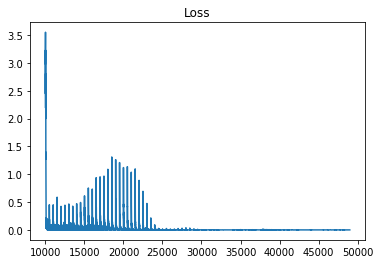

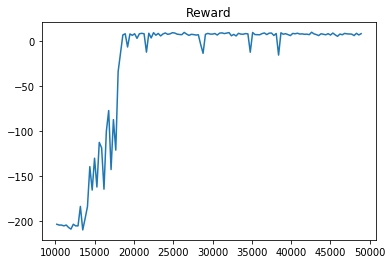

Step: 49200 Avg reward: 6.9
Step: 49500 Avg reward: 8.8
Step: 49800 Avg reward: 9.1


In [9]:
done = True
for step in range(num_steps):
    if done:
        state_idx = env.reset()
        state = torch.zeros([input_size], dtype=torch.float32)
        state[state_idx] = 1
        
    action = network(state.unsqueeze(0)).max(1)[1].item()  # argmax_a Q(s_t, a)
    eps = max((eps_decay - step + learn_start) / eps_decay, eps_end)
    if random.random() < eps:  # take random action w.p. epsilon
        action = env.action_space.sample()
    
    next_state_idx, reward, done, _ = env.step(action)
    next_state = torch.zeros([input_size], dtype=torch.float32)
    next_state[next_state_idx] = 1
    
    # "Done due to timeout" is a non-markovian property.
    # This is an artifact which we would not like to learn from.
    if not (done and reward < 0):
        memory.add(state, action, reward, next_state, not done)
    state = next_state
    
    if step > learn_start:
        batch_state, batch_action, batch_reward, batch_next_state, not_done_mask = memory.sample(batch)
        
        batch_state = torch.stack(batch_state)
        batch_next_state = torch.stack(batch_next_state)
        batch_action = torch.tensor(batch_action, dtype=torch.int64).unsqueeze(-1)
        batch_reward = torch.tensor(batch_reward, dtype=torch.float32).unsqueeze(-1)
        not_done_mask = torch.tensor(not_done_mask, dtype=torch.float32).unsqueeze(-1)
        
        current_Q = network(batch_state).gather(1, batch_action)
        
        with torch.no_grad():
            if double_dqn:
                # Get actions "a_t" from network
                next_state_actions = network(batch_next_state).max(1, keepdim=True)[1]
                # Get value "Q(s, a_t)" from target
                next_Q = target_network(batch_next_state).gather(1, next_state_actions)
            else:
                next_Q = target_network(batch_next_state).max(1, keepdim=True)[0]
            target_Q = batch_reward + (gamma * next_Q) * not_done_mask
            
        # Smooth L1 loss acts like L2 near the optimum, yet like L1 when far from it.
        # While the real objective is the L2, empirically this results in a more stable training regime
        # as the L1 is less sensitive to outliers.
        loss = F.smooth_l1_loss(current_Q, target_Q)
        
        # Add L1 regularization
        all_params = torch.cat([x.view(-1) for x in network.parameters()])
        loss += l1_regularization * torch.norm(all_params, 1)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        losses_steps.append(step)
    
    if step % target_update_freq == 0:
        target_network.load_state_dict(network.state_dict())
    
    if step % eval_freq == 0 and step > learn_start:
        network.eval()
        total_reward = 0
        for eval_ep in range(eval_episodes):
            eval_state_idx = eval_env.reset()
            while True:
                eval_state = torch.zeros([input_size], dtype=torch.float32)
                eval_state[eval_state_idx] = 1

                action = network(eval_state.unsqueeze(0)).max(1)[1].item()
                if random.random() < 0.01:
                    action = random.randrange(output_size)
                eval_state_idx, reward, done, _ = eval_env.step(action)
                
                total_reward += reward
                if done:
                    break
        network.train()
        
        average_reward = total_reward * 1.0 / eval_episodes
        average_rewards.append(average_reward)
        avg_rew_steps.append(step)
        print('Step: ' + str(step) + ' Avg reward: ' + str(average_reward))
    
    if step > learn_start and len(losses) > 0 and len(average_rewards) > 0 and step % 1000 == 0:
        clear_output()
        pl.plot(losses_steps, losses)
        pl.title('Loss')
        pl.show()
        pl.plot(avg_rew_steps, average_rewards)
        pl.title('Reward')
        pl.show()

# Save network

In [10]:
# torch.save(network.state_dict(), 'dqn')

# Load network

In [11]:
network.load_state_dict(torch.load('dqn'))

In [12]:
network.eval()

DQN_MLP(
  (lin1): Linear(in_features=500, out_features=50, bias=True)
  (dropout1): Dropout(p=0)
  (lin2): Linear(in_features=50, out_features=6, bias=True)
  (dropout2): Dropout(p=0)
)

# Evaluate network (one run with visualization)

In [13]:
eval_state_idx = eval_env.reset()
while True:
    eval_env.render()
    eval_state = torch.zeros([input_size], dtype=torch.float32)
    eval_state[eval_state_idx] = 1

    q_vals = network(eval_state.unsqueeze(0))
    print(q_vals)
    action = q_vals.max(1)[1].item()
    eval_state_idx, reward, done, _ = eval_env.step(action)

    if done:
        break
eval_env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

tensor([[ 8.5613,  6.4566,  7.4642,  7.4585, -1.5581, -1.5707]])
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
tensor([[ 8.5917,  7.4330,  8.5618,  8.5441,  9.6562, -0.4561]])
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
tensor([[  9.6640,  10.9121,   9.7002,   9.6401,   0.8491,   8.5096]])
+---------+
|R: | : :G|
| : : : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)
tensor([[  9.6841,  11.9443,  10.9282,  10.8279,   1.9103,   1.9200]])
+---------+
|R: | : :G|
| : : : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
tensor([[ 10.9034,  13.0000,  13.0385,  11.9274,   3.0072,   2.9374]])
+---------+
|R: | : :G|
| : : : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
tensor([[ 11.8683,  14.2115,  14.1954,  11.9413,   4.0283,   4.0006]])
+---------+
|R: | : :G|
| :_: :

# Evaluate network with mean and std outputs

In [14]:
rews = []
for _ in range(1000):
    eval_state_idx = eval_env.reset()
    rew = 0
    while True:
        eval_state = torch.zeros([input_size], dtype=torch.float32)
        eval_state[eval_state_idx] = 1

        q_vals = network(eval_state.unsqueeze(0))
        action = q_vals.max(1)[1].item()
        eval_state_idx, reward, done, _ = eval_env.step(action)

        rew += reward
        
        if done:
            break
    rews.append(rew)
print('Average reward: ' + str(np.mean(rews)))
print('STD: ' + str(np.std(rews)))

Average reward: 8.488
STD: 2.363441558405877
